In [22]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# Define base directory
base_dir = Path('/Users/tabassum221b/Downloads/NetflixProject').resolve()

# Define specific folders
data_dir = base_dir / 'netflix-report'
notebook_dir = base_dir / 'notebook'

# Read data
viewing_activity = pd.read_csv(data_dir/'CONTENT_INTERACTION'/'ViewingActivity_Updated.csv')
messages = pd.read_csv(data_dir/'MESSAGES'/'MessagesSentByNetflix.csv')

In [24]:
viewing_activity.columns

Index(['Profile Name', 'Start Time', 'Duration', 'Title', 'Device Type',
       'Country', 'User', 'Duration (min)', 'Duration (hr)', 'Start Time UTC',
       'Year', 'Month', 'Date_of_month', 'day_of_week', 'day_name', 'TV Show',
       'Season', 'Episode', 'Content Type', 'Date'],
      dtype='object')

### Are all profiles being used equally ?

Note : Profile Oishi is shared by 2 users

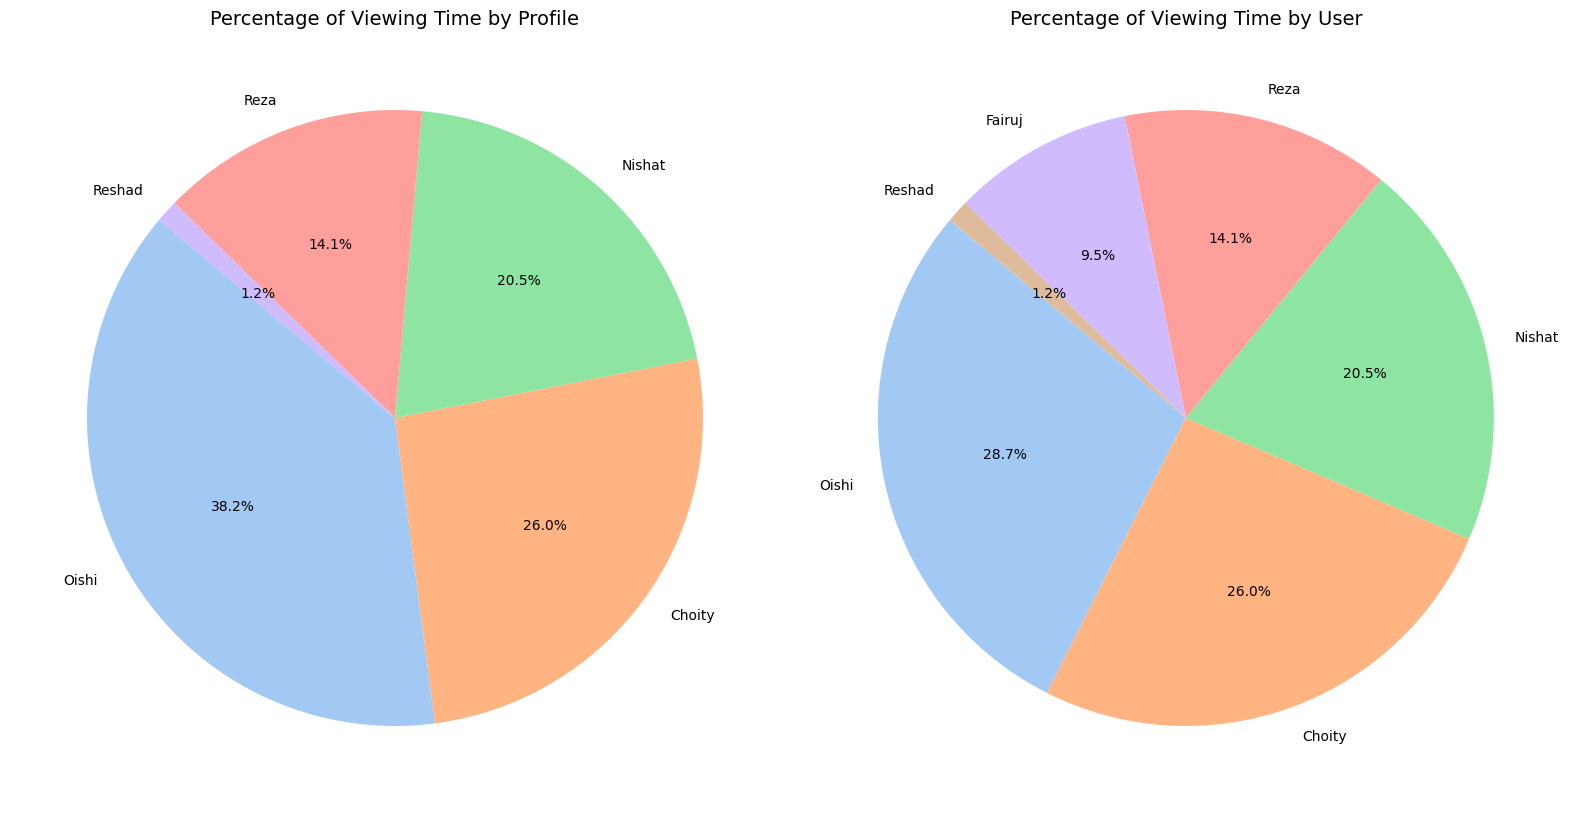

Profile Duration Percentage:
   Profile Name  Total_Duration_hr  Percentage
2        Oishi             197.60   38.186526
0       Choity             134.66   26.023267
1       Nishat             106.05   20.494338
4         Reza              73.03   14.113168
3       Reshad               6.12    1.182700

User Duration Percentage:
      User  Total_Duration_hr  Percentage
3   Oishi             148.33   28.665018
0  Choity             134.66   26.023267
2  Nishat             106.05   20.494338
5    Reza              73.03   14.113168
1  Fairuj              49.27    9.521509
4  Reshad               6.12    1.182700


In [25]:
# Calculate the percentage for each profile
profile_duration_percentage = viewing_activity.groupby('Profile Name').agg(
    Total_Duration_hr=('Duration (hr)', 'sum')
).reset_index()

profile_duration_percentage['Percentage'] = (
    profile_duration_percentage['Total_Duration_hr'] / profile_duration_percentage['Total_Duration_hr'].sum()
) * 100

profile_duration_percentage = profile_duration_percentage.sort_values(by='Percentage', ascending=False)
profile_colors = sns.color_palette('pastel', len(profile_duration_percentage))

# Calculate the percentage for each user
user_duration_percentage = viewing_activity.groupby('User').agg(
    Total_Duration_hr=('Duration (hr)', 'sum')
).reset_index()

user_duration_percentage['Percentage'] = (
    user_duration_percentage['Total_Duration_hr'] / user_duration_percentage['Total_Duration_hr'].sum()
) * 100

user_duration_percentage = user_duration_percentage.sort_values(by='Percentage', ascending=False)
user_colors = sns.color_palette('pastel', len(user_duration_percentage))

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Profile Pie Chart
axes[0].pie(
    profile_duration_percentage['Percentage'],
    labels=profile_duration_percentage['Profile Name'],
    autopct='%1.1f%%',
    startangle=140,
    colors=profile_colors
)
axes[0].set_title('Percentage of Viewing Time by Profile', fontsize=14)

# User Pie Chart
axes[1].pie(
    user_duration_percentage['Percentage'],
    labels=user_duration_percentage['User'],
    autopct='%1.1f%%',
    startangle=140,
    colors=user_colors
)
axes[1].set_title('Percentage of Viewing Time by User', fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print data for reference
print("Profile Duration Percentage:\n", profile_duration_percentage)
print("\nUser Duration Percentage:\n", user_duration_percentage)


### Viewing patters

/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/3711639659.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


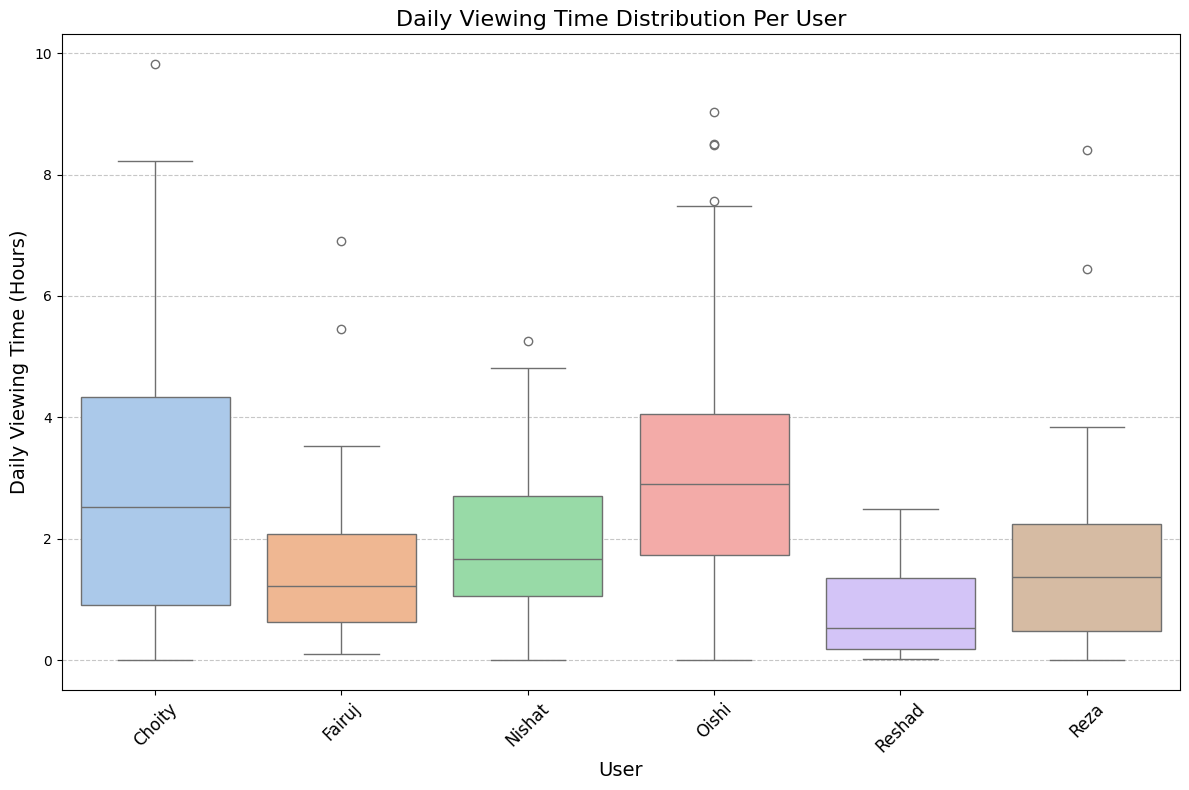

In [26]:
# Group data by User and Date to calculate daily viewing patterns
daily_patterns = (
    viewing_activity.groupby(['User', 'Date'])['Duration (hr)']
    .sum()
    .reset_index()
)
# Box plot: Daily viewing time distribution per user
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=daily_patterns,
    x='User',
    y='Duration (hr)',
    palette='pastel'
)
plt.title('Daily Viewing Time Distribution Per User', fontsize=16)
plt.ylabel('Daily Viewing Time (Hours)', fontsize=14)
plt.xlabel('User', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Weekly viewing patters

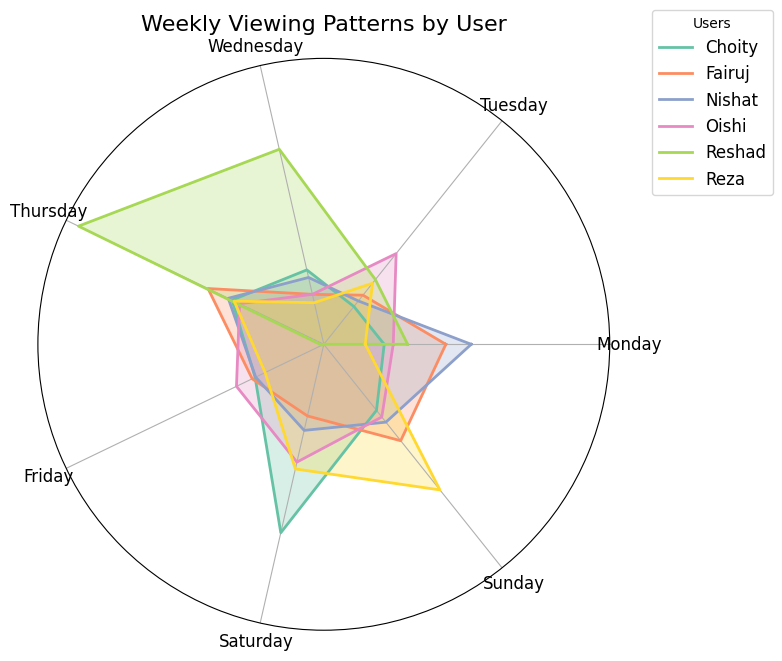

In [27]:
# Prepare the data: Total viewing time per user for each day
weekly_data = viewing_activity.groupby(['User', 'day_name'])['Duration (hr)'].sum().reset_index()

# Ensure days are in order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_data['day_name'] = pd.Categorical(weekly_data['day_name'], categories=days_order, ordered=True)

# Pivot to create a matrix: Users as rows, Days as columns
weekly_pivot = weekly_data.pivot(index='User', columns='day_name', values='Duration (hr)').fillna(0)

# Normalize data for comparison
weekly_pivot_normalized = weekly_pivot.div(weekly_pivot.sum(axis=1), axis=0)

# Radar chart setup
def create_combined_radar_chart(data, categories):
    users = data.index
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    colors = plt.cm.Set2.colors  # Distinct colors for each user

    for i, user in enumerate(users):
        values = data.loc[user].tolist()
        values += values[:1]  # Close the radar chart loop
        ax.plot(angles, values, color=colors[i], linewidth=2, label=user)
        ax.fill(angles, values, color=colors[i], alpha=0.25)

    # Configure the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticks([])
    ax.set_title('Weekly Viewing Patterns by User', size=16, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title='Users', fontsize=12)

    plt.tight_layout()
    plt.show()

# Define categories (days of the week)
categories = days_order

# Call the function to create the combined radar chart
create_combined_radar_chart(weekly_pivot_normalized, categories)


### Binge Watching

In [28]:
# Filter for TV Shows
tv_shows = viewing_activity[viewing_activity['Content Type'] == 'TV Show']

# Handle Missing Episodes
tv_shows['Episode'] = tv_shows['Episode'].fillna(tv_shows['Season'])

# Group by User, TV Show, and Date to Count Episodes Watched Per Day
binge_watch_data = (
    tv_shows.groupby(['User', 'TV Show', 'Date'])['Episode']
    .count()
    .reset_index()
    .rename(columns={'Episode': 'Episode_Count'})
)

# Define Binge-Watching (4+ episodes in one day)
binge_watch_data['Is_Binge'] = binge_watch_data['Episode_Count'] >= 4

# Aggregate Data for Analysis
binge_watch_summary = binge_watch_data[binge_watch_data['Is_Binge']]
#binge_watch_summary

/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/3610915140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['Episode'] = tv_shows['Episode'].fillna(tv_shows['Season'])


In [29]:
# Most Binge-Watched Shows Overallv
top_binge_shows = (
    binge_watch_summary.groupby('TV Show')['Is_Binge']
    .sum()
    .reset_index()
    .rename(columns={'Is_Binge': 'Binge_Count'})
    .sort_values(by='Binge_Count', ascending=False)
)

#print("Top Binge-Watched Shows:\n", top_binge_shows)

/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/609400519.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


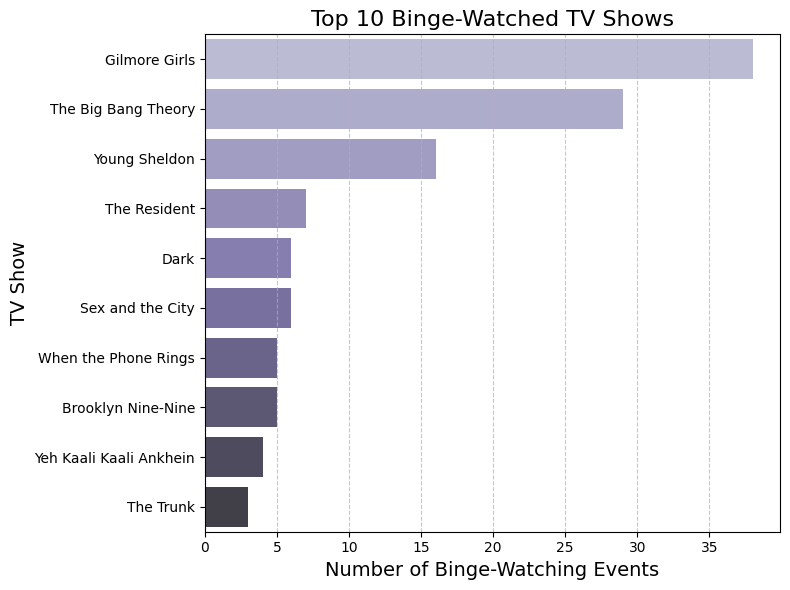

In [30]:
# Get the top 10 binge-watched shows
top_10_binge_shows = top_binge_shows.head(10)

# Horizontal bar plot for the top 10 binge-watched shows
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_binge_shows,
    y='TV Show',
    x='Binge_Count',
    palette='Purples_d'
)

# Add labels and title
plt.title('Top 10 Binge-Watched TV Shows', fontsize=16)
plt.xlabel('Number of Binge-Watching Events', fontsize=14)
plt.ylabel('TV Show', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
# Calculate the number of unique binge-watching days per user
binge_watch_days = (
    binge_watch_summary.groupby('User')['Date']
    .nunique()  # Count unique dates for each user
    .reset_index()
    .rename(columns={'Date': 'Binge_Watch_Days'})
    .sort_values(by='Binge_Watch_Days', ascending=False)
)

print("\nBinge-Watching Days by User:\n", binge_watch_days)


Binge-Watching Days by User:
      User  Binge_Watch_Days
2  Nishat                43
3   Oishi                33
0  Choity                24
5    Reza                24
1  Fairuj                17
4  Reshad                 3


/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/3361867209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


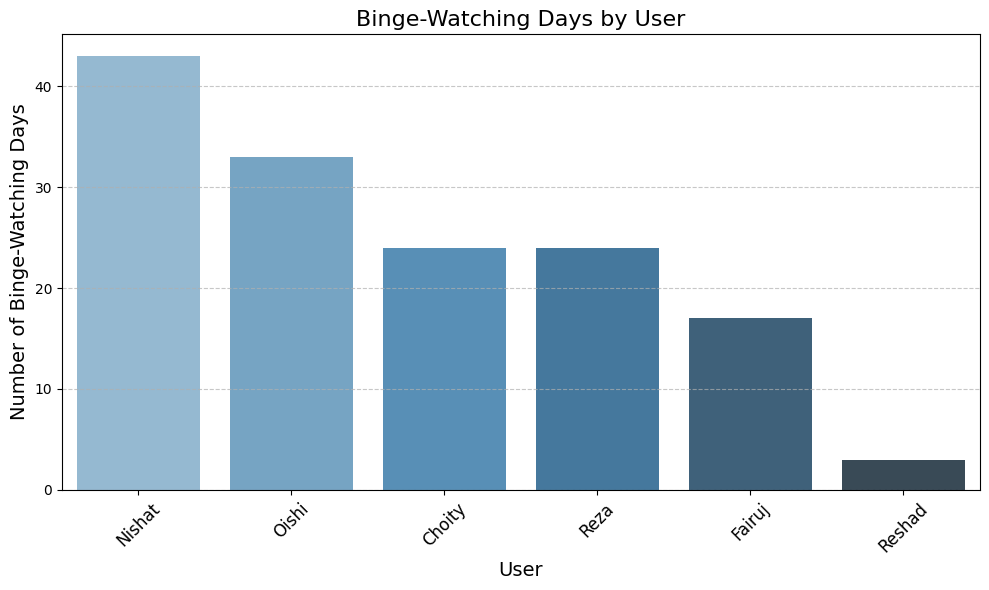

In [32]:
# Plot the number of binge-watching days per user
plt.figure(figsize=(10, 6))
sns.barplot(
    data=binge_watch_days,
    x='User',
    y='Binge_Watch_Days',
    palette='Blues_d'
)

# Add labels and title
plt.title('Binge-Watching Days by User', fontsize=16)
plt.ylabel('Number of Binge-Watching Days', fontsize=14)
plt.xlabel('User', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

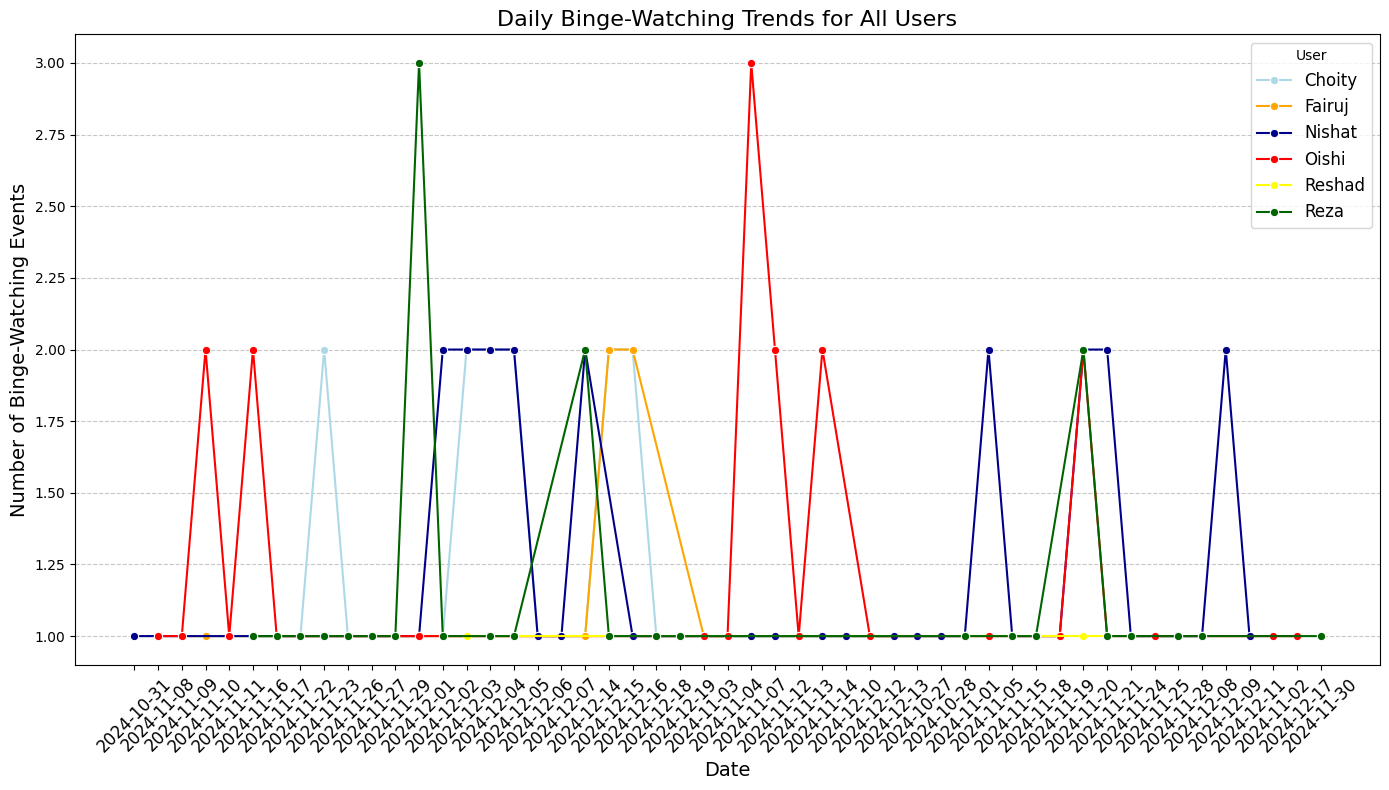

In [33]:
# Group data by User and Date for binge-watching trends
binge_trends = (
    binge_watch_summary.groupby(['User', 'Date'])['Is_Binge']
    .sum()
    .reset_index()
    .rename(columns={'Is_Binge': 'Binge_Count'})
)

custom_palette = {
    'Reza': 'darkgreen',
    'Oishi': 'red',
    'Fairuj': 'orange',
    'Nishat': 'darkblue',
    'Choity': 'lightblue',
    'Reshad': 'yellow'
}

# Plot all users' trends on the same graph
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=binge_trends,
    x='Date',
    y='Binge_Count',
    hue='User',
    marker='o',
    palette=custom_palette
)

# Add labels and title
plt.title('Daily Binge-Watching Trends for All Users', fontsize=16)
plt.ylabel('Number of Binge-Watching Events', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='User', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


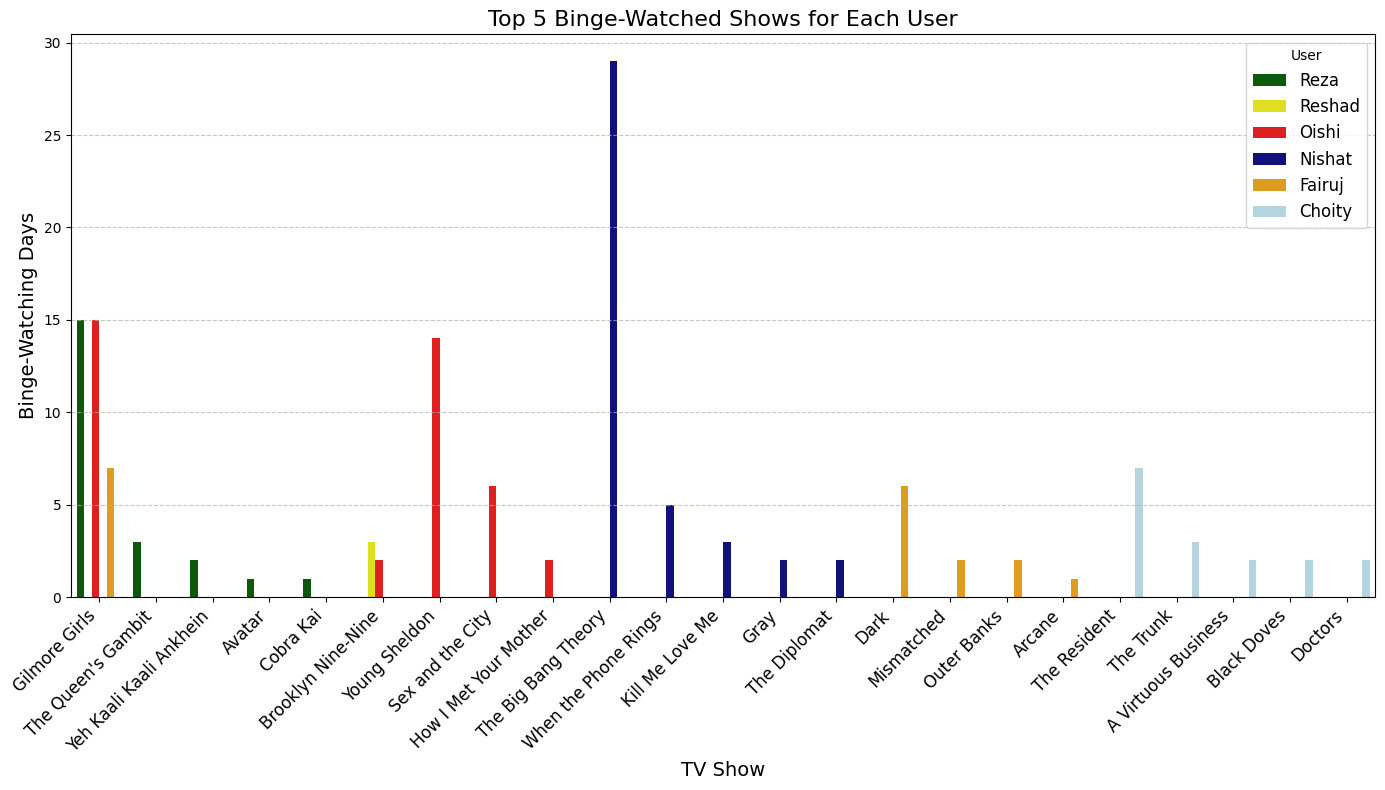

In [34]:
# Filter Top 5 Binge-Watched Shows for Each User
top_5_binge_per_user = (
    binge_watch_summary.groupby(['User', 'TV Show'])['Date']
    .count()  # Count binge-watching days for each show
    .reset_index()
    .rename(columns={'Date': 'Binge_Days'})
    .sort_values(by=['User', 'Binge_Days'], ascending=False)
    .groupby('User')
    .head(5)  # Select top 5 shows per user
)

# Define custom colors for each user
custom_palette = {
    'Reza': 'darkgreen',
    'Oishi': 'red',
    'Fairuj': 'orange',
    'Nishat': 'darkblue',
    'Choity': 'lightblue',
    'Reshad': 'yellow'
}

# Create a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_5_binge_per_user,
    x='TV Show',
    y='Binge_Days',
    hue='User',
    palette=custom_palette
)

# Customize the plot
plt.title('Top 5 Binge-Watched Shows for Each User', fontsize=16)
plt.ylabel('Binge-Watching Days', fontsize=14)
plt.xlabel('TV Show', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate TV show labels for readability
plt.legend(title='User', fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Favourite shows

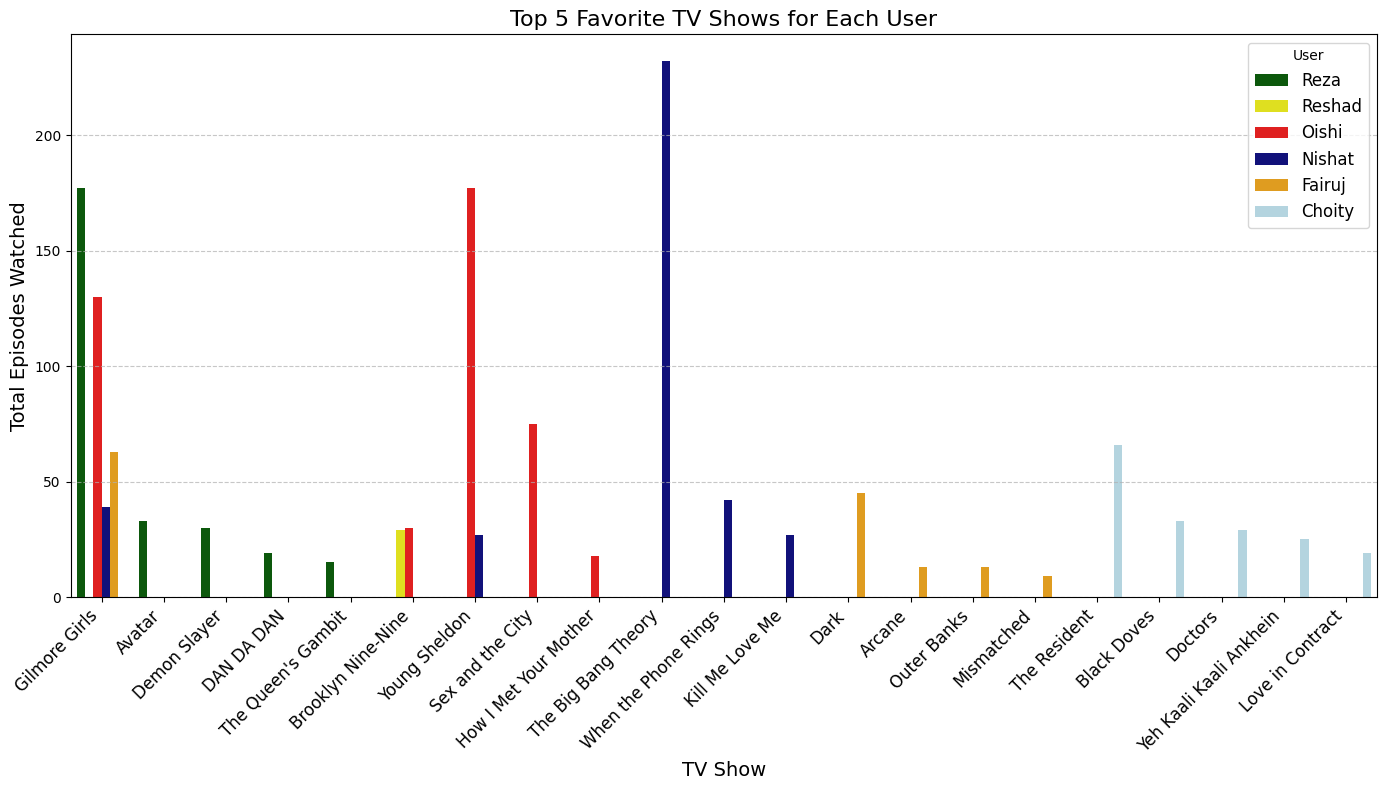

In [35]:
# Group data by User and TV Show to count total episodes watched
favorite_shows = (
    viewing_activity[viewing_activity['Content Type'] == 'TV Show']
    .groupby(['User', 'TV Show'])['Episode']
    .count()  # Count episodes watched
    .reset_index()
    .rename(columns={'Episode': 'Total_Episodes'})
    .sort_values(by=['User', 'Total_Episodes'], ascending=False)
)

# Extract top 5 favorite shows for each user
top_5_fav_shows_per_user = (
    favorite_shows.groupby('User')
    .head(5)  # Select top 5 shows for each user
)


# Create a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_5_fav_shows_per_user,
    x='TV Show',
    y='Total_Episodes',
    hue='User',
    palette=custom_palette
)

# Customize the plot
plt.title('Top 5 Favorite TV Shows for Each User', fontsize=16)
plt.ylabel('Total Episodes Watched', fontsize=14)
plt.xlabel('TV Show', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate TV show labels for readability
plt.legend(title='User', fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Analyze Message Engagement

Click-Through Rate (CTR) by Profile:
  Profile Name  Total_Messages  Total_Clicks    CTR (%)
0       Choity             127            22  17.322835
1       Nishat             103            15  14.563107
2        Oishi              39             0   0.000000
3       Reshad               2             0   0.000000
4         Reza              24             0   0.000000


/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/1535998594.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


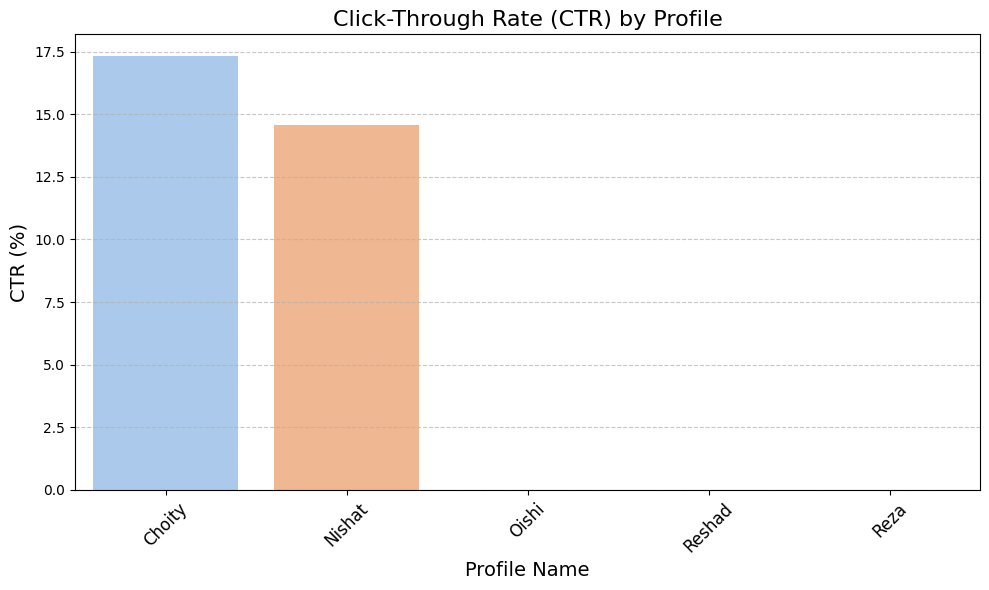

In [36]:
# Ensure 'Sent Utc Ts' and 'Click Utc Ts' are in datetime format
messages['Sent Utc Ts'] = pd.to_datetime(messages['Sent Utc Ts'], errors='coerce')
messages['Click Utc Ts'] = pd.to_datetime(messages['Click Utc Ts'], errors='coerce')

# Calculate Click-Through Rate (CTR)
messages['CTR'] = (messages['Click Cnt'] > 0).astype(int)  # 1 if clicked, 0 otherwise

# Aggregate CTR by user
user_ctr = (
    messages.groupby('Profile Name')
    .agg(
        Total_Messages=('CTR', 'count'),
        Total_Clicks=('CTR', 'sum')
    )
    .reset_index()
)

# Add CTR percentage
user_ctr['CTR (%)'] = (user_ctr['Total_Clicks'] / user_ctr['Total_Messages']) * 100

# Display the results
print("Click-Through Rate (CTR) by Profile:")
print(user_ctr)

# --- Visualization ---
# Bar plot of CTR per user
plt.figure(figsize=(10, 6))
sns.barplot(
    data=user_ctr,
    x='Profile Name',
    y='CTR (%)',
    palette='pastel'
)
plt.title('Click-Through Rate (CTR) by Profile', fontsize=16)
plt.ylabel('CTR (%)', fontsize=14)
plt.xlabel('Profile Name', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [37]:
# Convert 'Start Time UTC' to datetime
viewing_activity['Start Time UTC'] = pd.to_datetime(viewing_activity['Start Time UTC'], errors='coerce')

# Join messages with viewing_activity on Profile Name and Title
merged_data = pd.merge(
    messages,
    viewing_activity,
    left_on=['Profile Name', 'Title Name'],
    right_on=['Profile Name', 'Title'],
    how='inner'
)

# Calculate the time difference between message sent and show viewed
merged_data['Time_Difference'] = (merged_data['Start Time UTC'] - merged_data['Sent Utc Ts']).dt.days

# Filter for influenced views (within 7 days of receiving the message)
influenced_views = merged_data[(merged_data['Time_Difference'] >= 0) & (merged_data['Time_Difference'] <= 7)]

# Aggregate metrics
# Total messages sent, influenced views, and total views
user_metrics = viewing_activity.groupby('User')['Title'].nunique().reset_index().rename(columns={'Title': 'Total_Viewed_Shows'})
influenced_metrics = influenced_views.groupby('User').agg(
    Total_Messages=('Title Name', 'count'),
    Influenced_Views=('Title', 'nunique')
).reset_index()

# Merge metrics to calculate percentages
final_metrics = pd.merge(user_metrics, influenced_metrics, on='User', how='left').fillna(0)
final_metrics['Influence (% of Messages)'] = (final_metrics['Influenced_Views'] / final_metrics['Total_Messages']) * 100
final_metrics['Influence (% of Total Views)'] = (final_metrics['Influenced_Views'] / final_metrics['Total_Viewed_Shows']) * 100


In [38]:
# Display the results
print("Enhanced Influence of Messages on Viewing Behavior:")
final_metrics

Enhanced Influence of Messages on Viewing Behavior:


,User,Total_Viewed_Shows,Total_Messages,Influenced_Views,Influence (% of Messages),Influence (% of Total Views)
0,Choity,274,0.0,0.0,NaN,0.000000
1,Fairuj,73,0.0,0.0,NaN,0.000000
2,Nishat,305,31.0,4.0,12.903226,1.311475
3,Oishi,302,0.0,0.0,NaN,0.000000
4,Reshad,21,0.0,0.0,NaN,0.000000
5,Reza,189,2.0,1.0,50.000000,0.529101


/var/folders/h1/kwz10shx6gv77h3fhd8q3nh80000gn/T/ipykernel_876/332091515.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


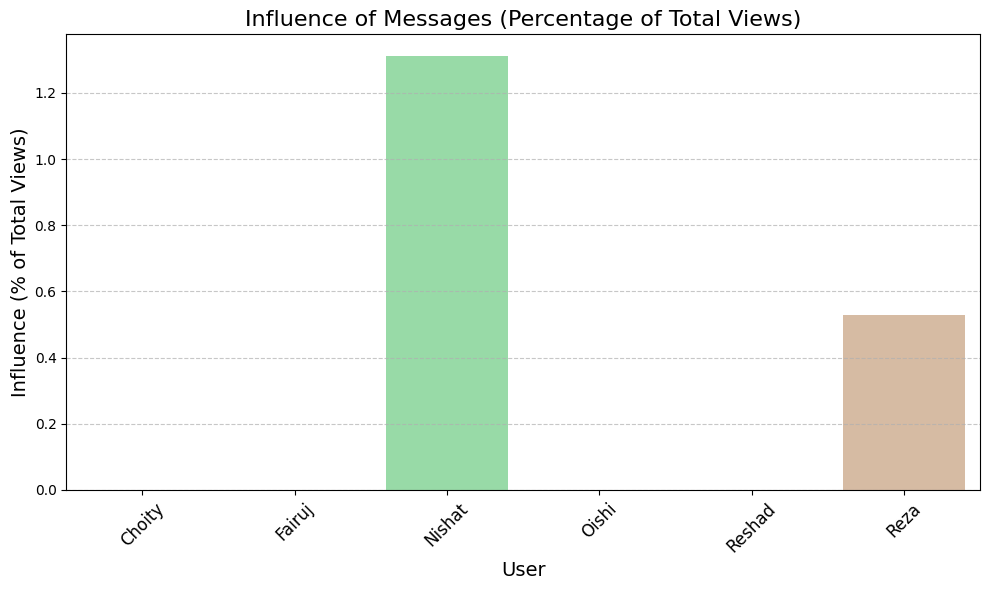

In [39]:
# Percentage of shows influenced by messages (out of total viewed shows)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=final_metrics,
    x='User',
    y='Influence (% of Total Views)',
    palette='pastel'
)
plt.title('Influence of Messages (Percentage of Total Views)', fontsize=16)
plt.ylabel('Influence (% of Total Views)', fontsize=14)
plt.xlabel('User', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()